In [12]:
import numpy as np
import datetime
import pandas as pd

import time
import pickle
import os
from pathlib import Path

from math import log10, floor

import matplotlib.pyplot as plt
import matplotlib



In [275]:
class Country(object):
    def __init__(self,name,iso):
        self.name = name
        self.iso = iso
        
        # number of cases per day
        self.raw_data = {"cases":None,"deaths":None,"hospitalized":None,"ICU":None}
        self.data = {}
        self.weekly = {}
        
        # Different hooks along the pre-processing
        self.Load()
        self.Process()
        self.GenWeeklySeries()
        # Now contains a weekly dataseries
        
    def Load(self):
        pass
    
    def Process(self):
        pass
    
    def GenWeeklySeries(self,data=None):
        if data == None:
            data = self.data
        for k,v in data.items():
            self.weekly[k] = v.resample('W',label='left').sum()
             
    def IsAvailable(self,key):
        return self.data.get(key,None) != None
                
class BasicCountry(Country):
    def __init__(self,name,iso):
        super(BasicCountry,self).__init__(name,iso)
        
    def Load(self):
        for k in self.raw_data.keys():
            fn_full = "../DataByAge/"+iso+"/"+k+".csv"
            try:
                df = pd.read_csv(fn_full,header=0,index_col=0)
                self.raw_data[k] = df
            except:
                pass
            
    def Process(self,data=None):
        if data == None:
            data = self.raw_data
            
        replace = {"80-":"80+"}
        unused = ["confirmed","deaths"]
        for k,v in data.items():
            if type(v) != type(None):
                columns = v.columns
            
                def replace_index(r):
                    if r in replace.keys():
                        r = replace[r]
                    return r
            
                columns = map(replace_index,columns)
                
                
                def remove_unused(r):
                    for u in unused:
                        if u in r:
                            r = r.replace(u,"").lstrip()
                    return r
                
                v.columns = map(remove_unused,columns)
                v.index = pd.to_datetime(list(v.index))
                
                self.data[k] = v
                
class RemoveNamedDoubleIndex(BasicCountry):
    def __init__(self,name,iso):
        super(RemoveNamedDoubleIndex,self).__init__(name,iso)
        
    def Process(self):
        for k,v in self.raw_data.items():
            if type(v) != type(None):
                columns = v.columns
                
                def remove_double_index(r):
                    if "(" in r and ")" in r and "," in r:
                        r = r.split("'")[3]
                    return r
                        
                v.columns = map(remove_double_index,columns)
                
                def parse_datetime(s):
                    return datetime.datetime.strptime(s,'%d-%m-%Y')
                
                v.index = map(parse_datetime,v.index)
        super(RemoveNamedDoubleIndex,self).Process(self.raw_data)
    
class Swizerland(BasicCountry):
    def __init__(self,name,iso):
        super(Swizerland,self).__init__(name,iso)
        
    def Process(self):
        data = {}
        for k,v in self.raw_data.items():
            if type(v) != type(None):
                d = v.diff(axis=0)
                
                d = d.iloc[1:]
                data[k] = d
        super(Swizerland,self).Process(data)
        
class Germany(Country):
    def __init__(self,name,iso):
        super(Germany,self).__init__(name,iso)
        
    def Load(self):
        pass

In [276]:
cntrs = {}
cntrs["CZ"] = {"name":"Czech Republic","class":RemoveNamedDoubleIndex}
cntrs["NL"] = {"name":"Netherlands","class":RemoveNamedDoubleIndex}
cntrs["PRT"] = {"name":"Portugal","class":RemoveNamedDoubleIndex}
cntrs["BE"] = {"name":"Belgium","class":RemoveNamedDoubleIndex}

#cntrs["DE"] = {"name":"Germany","class":Germany}
cntrs["CHE"] = {"name":"Swizerland","class":Swizerland}

countries = {}
for iso,cntry in cntrs.items():
    countries[iso] = cntry["class"](cntry["name"],iso)


print(countries)

{'CZ': <__main__.RemoveNamedDoubleIndex object at 0x11c1ae3d0>, 'NL': <__main__.RemoveNamedDoubleIndex object at 0x11a801210>, 'PRT': <__main__.RemoveNamedDoubleIndex object at 0x11d832450>, 'BE': <__main__.RemoveNamedDoubleIndex object at 0x11d60c1d0>, 'CHE': <__main__.Swizerland object at 0x11ebc3cd0>}


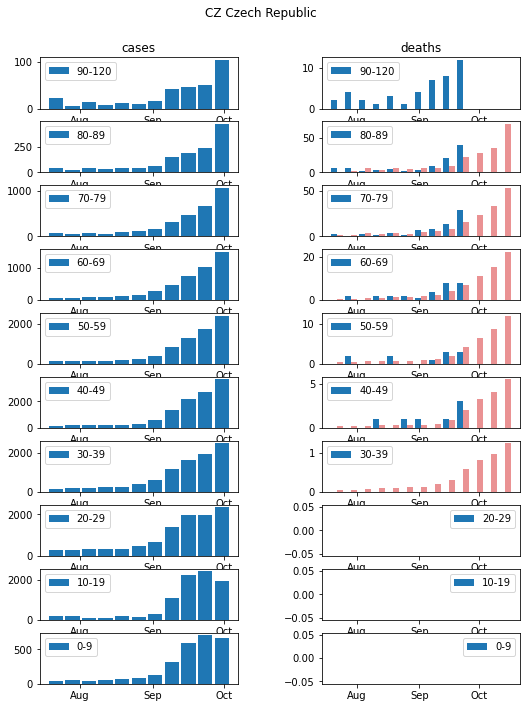

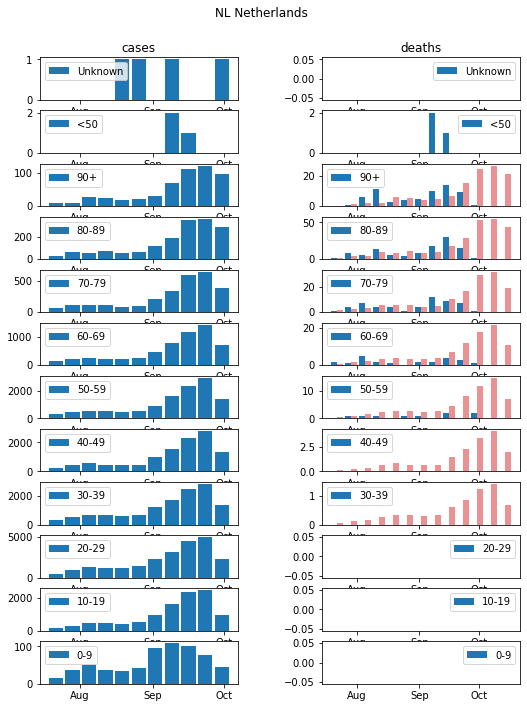

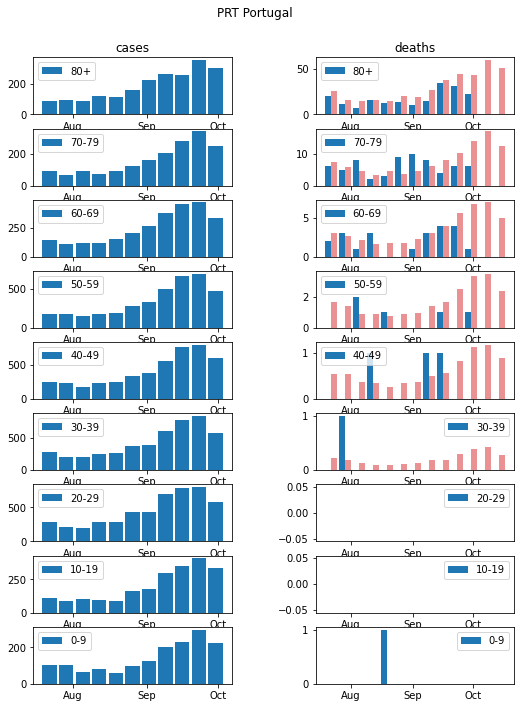

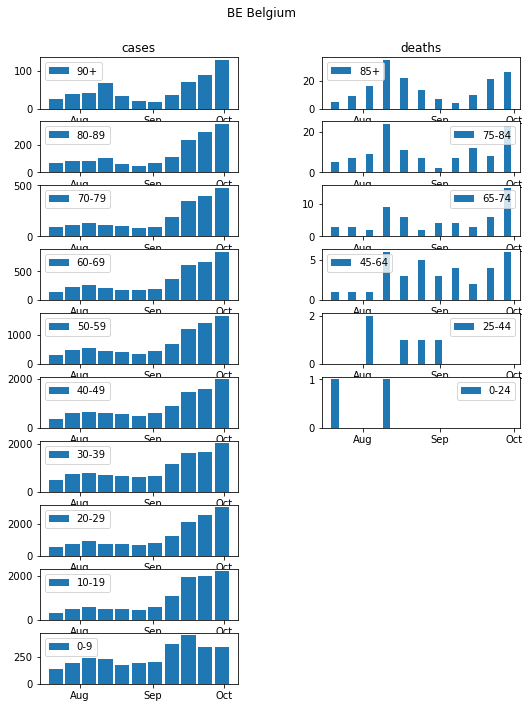

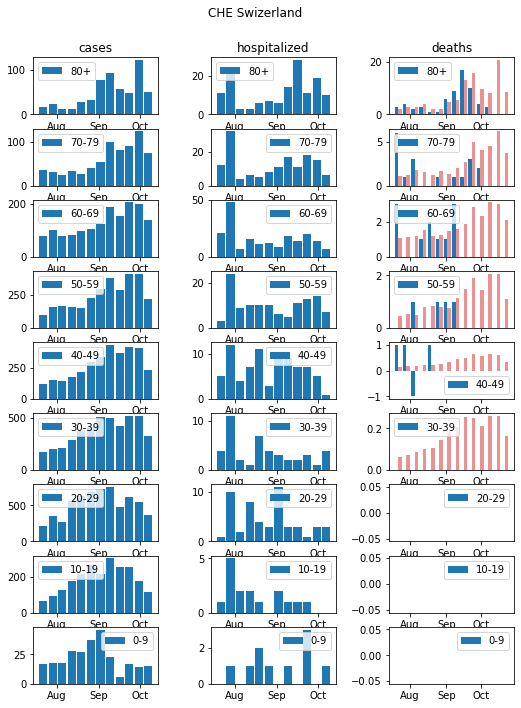

In [279]:
def ifr(s):
    return {"90+":.22,"80-89":.15,"80+":.17,"70-79":.05,"60-69":.015,"50-59":.005,"40-49":.0015,"30-39":.0005}.get(s,0.)

def ShowWeeklyOverview(country,start=datetime.datetime(2020,7,1)):
    
    data = country.weekly
    fig = plt.figure(figsize=(7.5,10))
    fig.subplots_adjust(wspace=0.425,hspace=0.25,left=0.09,right=0.98,top=0.91,bottom=0.04)
    
    possible_keys = ["cases","hospitalized","ICU","deaths"]
    keys = [x for x in possible_keys if x in data.keys()]
    n_ags = [len(data[x].columns) for x in keys]
    
    gs = fig.add_gridspec(max(n_ags), len(keys))
    
    
    
    splts = {}
    for i,k in enumerate(keys):
        splts[k] = {}
        for j,c in enumerate(data[k].columns[::-1]):
            ax = fig.add_subplot(gs[j,i])
            splts[k][c] = ax
            if j == 0:
                ax.set_title(k)
            # Formating
            ax.xaxis.set_major_locator( matplotlib.dates.MonthLocator() )
            ax.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b') )
    
    for i,k in enumerate(keys):
        for j,c in enumerate(data[k].columns):
            ds = data[k][c]
            ds = ds[start:]
            
            ax = splts[k][c]
            ax.bar(ds.index[2:],ds[2:],label=c,width={"deaths":3}.get(k,6),align="edge")
            if k == "cases":
                dx = splts["deaths"].get(c,None)
                if dx != None:
                    dx.bar(ds.index+datetime.timedelta(days=3+14),ds*ifr(c),width=3,align="edge",alpha=.5,color="tab:red")
                    
            ax.legend()
            
#            ax.set_xticks(xticks)
            
            
            
    
    fig.suptitle(country.iso+" "+country.name)
    fig.savefig("plots/"+country.iso+".pdf")

for k,v in countries.items():
    ShowWeeklyOverview(v)
#ShowWeeklyOverview(countries["CHE"])